In [101]:
from itertools import permutations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import svds

from sklearn.metrics import jaccard_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error

Pivoting your data

In this chapter, you will go one step further in generating personalized recommendations — you will find items that users, similar to the one you are making recommendations for, have liked.

The first step you will need to start with is formatting your data. You begin with a dataset containing users and their ratings as individual rows with the following columns:

user: User ID
title: Title of the movie
rating: Rating the user gave the movie
You will need to transform the DataFrame into a user rating matrix where each row represents a user, and each column represents the movies on the platform. This will allow you to easily compare users and their preferences.

In [2]:
user_ratings = pd.read_csv('user_ratings.csv')
user_ratings.reset_index(drop=True, inplace=True)
user_ratings

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


In [3]:
# Check for duplicates based on 'userId', 'movieId', and 'title'
user_ratings_duplicates = user_ratings[user_ratings.duplicated(subset=['userId', 'title', 'rating'], keep=False)]

user_ratings_duplicates['len_genres'] = user_ratings_duplicates['genres'].apply(len)

user_ratings_duplicates.sort_values(['userId','len_genres'])

C:\Users\Alienware\AppData\Local\Temp\ipykernel_20156\3972537108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_ratings_duplicates['len_genres'] = user_ratings_duplicates['genres'].apply(len)


,userId,movieId,rating,timestamp,title,genres,len_genres
73911,28,64997,3.5,1234850075,War of the Worlds (2005),Action|Sci-Fi,13
39411,28,34048,3.5,1234516420,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller,32
88958,111,6003,4.0,1516468531,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller,27
89385,111,144606,4.0,1517441257,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller,35
99604,509,26958,3.5,1436031753,Emma (1996),Romance,7
33526,509,838,3.5,1436031723,Emma (1996),Comedy|Drama|Romance,20


In [4]:
# I want to remove the duplicated with incomplete genres description (lower len_genres)

to_keep = user_ratings_duplicates.groupby('userId')['len_genres'].max()
to_keep.index, to_keep.values

(Index([28, 111, 509], dtype='int64', name='userId'),
 array([32, 35, 20], dtype=int64))

In [5]:
to_keep_indices = user_ratings_duplicates[user_ratings_duplicates.userId.isin(to_keep.index) & user_ratings_duplicates.len_genres.isin(to_keep.values)].index
to_keep_indices

Index([33526, 39411, 89385], dtype='int64')

In [6]:
to_remove_indices = user_ratings_duplicates[~user_ratings_duplicates.index.isin(to_keep_indices)].index
to_remove_indices

Index([73911, 88958, 99604], dtype='int64')

In [7]:
user_ratings_no_dupl = user_ratings[~user_ratings.index.isin(to_remove_indices)]
user_ratings_no_dupl

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


In [8]:
user_ratings_table = user_ratings_no_dupl.pivot_table(index='userId', columns='title', values='rating')

user_ratings_table

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


Compensating for incomplete data

For most datasets, the majority of users will have rated only a small number of items. As you saw in the last exercise, how you deal with users who do not have ratings for an item can greatly influence the validity of your models.

In this exercise, you will fill in missing data with information that should not bias the data that you do have.

You'll get the average score each user has given across all their ratings, and then use this average to center the users' scores around zero. Finally, you'll be able to fill in the empty values with zeros, which is now a neutral score, minimizing the impact on their overall profile, but still allowing the comparison of users.

In [9]:
# Get the average rating for each user 
avg_ratings = user_ratings_table.mean(axis=1)

avg_ratings

userId
1      4.366379
2      3.948276
3      2.435897
4      3.555556
5      3.636364
         ...   
606    3.657399
607    3.786096
608    3.134176
609    3.270270
610    3.688556
Length: 610, dtype: float64

In [10]:
# Center each users ratings around 0
user_ratings_table_centered = user_ratings_table.sub(avg_ratings, axis=0)

user_ratings_table_centered

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.366379,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.365824,0.365824,NaN,NaN,NaN


In [11]:
# Fill in the missing data with 0s
user_ratings_table_normed = user_ratings_table_centered.fillna(0)

user_ratings_table_normed

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.366379,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
607,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
608,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,1.365824,0.365824,0.000000,0.000000,0.0


Similar and different movie ratings

Some types of movies might be liked by one group of people, but hated by another. This might reflect the type of movie far more than its quality. Take, for example, horror movies — many people absolutely love them, while others hate them.

By understanding which movies were reviewed in a similar way, we can often find very similar movies.

In this exercise, you will compare movies and see whether they have received similar reviewing patterns.

In [12]:
movie_ratings_centered = user_ratings_table_normed.T
movie_ratings_centered

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.311444
'Hellboy': The Seeds of Creation (2004),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Round Midnight (1986),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Salem's Lot (2004),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Til There Was You (1997),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,1.492047,0.0,0.0,0.0,0.0,1.365824,0.0,0.000000
xXx (2002),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.26087,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.365824,0.0,-1.688556
xXx: State of the Union (2005),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,-2.188556


In [13]:
# Assign the arrays to variables
sw_IV = movie_ratings_centered.loc['Star Wars: Episode IV - A New Hope (1977)', :].values.reshape(1, -1)
sw_V = movie_ratings_centered.loc['Star Wars: Episode V - The Empire Strikes Back (1980)', :].values.reshape(1, -1)

# Find the similarity between two Star Wars movies
similarity_A = cosine_similarity(sw_IV, sw_V)
similarity_A

array([[0.69423917]])

In [14]:

# Assign the arrays to variables
jurassic_park = movie_ratings_centered.loc['Jurassic Park (1993)', :].values.reshape(1, -1)
pulp_fiction = movie_ratings_centered.loc['Pulp Fiction (1994)', :].values.reshape(1, -1)

# Find the similarity between Pulp Fiction and Jurassic Park
similarity_B = cosine_similarity(jurassic_park, pulp_fiction)
similarity_B

array([[0.03407117]])

Finding similarly liked movies

Just like you calculated the similarity between two movies, you can calculate it across all users to find the most similar movie to another based on how users have rated them.

The approach is similar to how you worked with content-based filtering.

You will find the similarity scores between all movies and then drill down on the movie of interest by isolating and sorting the column containing its similarity scores.

In [15]:
# Generate the similarity matrix
similarities = cosine_similarity(movie_ratings_centered)

print(similarities.shape)
similarities

(9719, 9719)


array([[ 1.        ,  0.        ,  0.        , ..., -0.61892332,
         0.        ,  0.        ],
       [ 0.        ,  1.        , -0.23408571, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.23408571,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.61892332,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

In [16]:
movie_ratings_centered.index

Index([''71 (2014)', ''Hellboy': The Seeds of Creation (2004)',
       ''Round Midnight (1986)', ''Salem's Lot (2004)',
       ''Til There Was You (1997)', ''Tis the Season for Love (2015)',
       ''burbs, The (1989)', ''night Mother (1986)',
       '(500) Days of Summer (2009)', '*batteries not included (1987)',
       ...
       'Zulu (2013)', '[REC] (2007)', '[REC]² (2009)',
       '[REC]³ 3 Génesis (2012)',
       'anohana: The Flower We Saw That Day - The Movie (2013)',
       'eXistenZ (1999)', 'xXx (2002)', 'xXx: State of the Union (2005)',
       '¡Three Amigos! (1986)', 'À nous la liberté (Freedom for Us) (1931)'],
      dtype='object', name='title', length=9719)

In [17]:
# Wrap the similarities in a DataFrame
cosine_similarity_df = pd.DataFrame(similarities, index=movie_ratings_centered.index, columns=movie_ratings_centered.index)
cosine_similarity_df

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.029814,0.000000,...,0.000000,0.136672,-0.191027,-0.715017,0.0,0.000000,-0.303417,-0.618923,0.000000,0.0
'Hellboy': The Seeds of Creation (2004),0.000000,1.000000,-0.234086,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Round Midnight (1986),0.000000,-0.234086,1.000000,0.000000,0.000000,0.0,0.092154,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Salem's Lot (2004),0.000000,0.000000,0.000000,1.000000,0.861417,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Til There Was You (1997),0.000000,0.000000,0.000000,0.861417,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.004539,-0.144652,-0.120629,-0.026031,...,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.082614,0.000000,-0.128188,0.0
xXx (2002),-0.303417,0.000000,0.000000,0.000000,0.000000,0.0,0.052993,0.000000,-0.010918,0.110208,...,0.331954,-0.367605,0.140472,0.301522,0.0,0.082614,1.000000,0.477624,-0.011111,0.0
xXx: State of the Union (2005),-0.618923,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.040262,0.000000,...,0.000000,-0.485683,0.118231,0.442541,0.0,0.000000,0.477624,1.000000,0.000000,0.0


In [18]:
# Find the similarity values for a specific movie
cosine_similarity_series = cosine_similarity_df.loc['Star Wars: Episode IV - A New Hope (1977)']

ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

ordered_similarities

title
Star Wars: Episode IV - A New Hope (1977)                                         1.000000
Star Wars: Episode V - The Empire Strikes Back (1980)                             0.694239
Star Wars: Episode VI - Return of the Jedi (1983)                                 0.646330
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    0.449865
Indiana Jones and the Last Crusade (1989)                                         0.404551
                                                                                    ...   
Angels in the Outfield (1994)                                                    -0.299073
Superman III (1983)                                                              -0.302429
Bio-Dome (1996)                                                                  -0.313563
Rambo III (1988)                                                                 -0.316152
Batman & Robin (1997)                                                            -0.

Stepping through K-nearest neighbors

You have just seen how K-nearest neighbors can be used to infer how someone might rate an item based on the wisdom of a (similar) crowd. In this exercise, you will step through this process yourself to ensure a good understanding of how it works.

First a user_similarity matrix must be created, using cosine similarity, then you will be working with user_001's similarity scores, find their nearest neighbors, and based on the ratings those neighbors gave a movie, infer what rating user_001 might give it if they saw it.

In [19]:
user_similarities = cosine_similarity(user_ratings_table_normed)
user_similarities

array([[ 1.00000000e+00,  1.26451574e-03,  5.52577176e-04, ...,
         7.52238457e-02, -2.57125541e-02,  1.09323166e-02],
       [ 1.26451574e-03,  1.00000000e+00,  0.00000000e+00, ...,
        -6.00082818e-03, -6.00909967e-02,  2.49992083e-02],
       [ 5.52577176e-04,  0.00000000e+00,  1.00000000e+00, ...,
        -1.30006374e-02,  0.00000000e+00,  1.95499646e-02],
       ...,
       [ 7.52238457e-02, -6.00082818e-03, -1.30006374e-02, ...,
         1.00000000e+00,  5.07144903e-02,  5.44538770e-02],
       [-2.57125541e-02, -6.00909967e-02,  0.00000000e+00, ...,
         5.07144903e-02,  1.00000000e+00, -1.24714266e-02],
       [ 1.09323166e-02,  2.49992083e-02,  1.95499646e-02, ...,
         5.44538770e-02, -1.24714266e-02,  1.00000000e+00]])

In [20]:
user_similarities = pd.DataFrame(user_similarities, index=user_ratings_table_normed.index, columns=user_ratings_table_normed.index)
user_similarities

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.001265,0.000553,0.048419,0.021847,-0.045497,-0.006200,0.047013,0.019510,-0.008754,...,0.018127,-0.017172,-0.015221,-0.037059,-0.029121,0.012016,0.055261,0.075224,-0.025713,0.010932
2,0.001265,1.000000,0.000000,-0.017164,0.021796,-0.021051,-0.011114,-0.048085,0.000000,0.003012,...,-0.050551,-0.031581,-0.001688,0.000000,0.000000,0.006226,-0.020504,-0.006001,-0.060091,0.024999
3,0.000553,0.000000,1.000000,-0.011260,-0.031539,0.004800,0.000000,-0.032471,0.000000,0.000000,...,-0.004904,-0.016117,0.017749,0.000000,-0.001431,-0.037289,-0.007789,-0.013001,0.000000,0.019550
4,0.048419,-0.017164,-0.011260,1.000000,-0.029620,0.013956,0.058091,0.002065,-0.005874,0.051590,...,-0.037687,0.063122,0.027640,-0.013782,0.040037,0.020590,0.014628,-0.037569,-0.017884,-0.000995
5,0.021847,0.021796,-0.031539,-0.029620,1.000000,0.009111,0.010117,-0.012284,0.000000,-0.033165,...,0.015964,0.012427,0.027076,0.012461,-0.036272,0.026319,0.031896,-0.001751,0.093829,-0.000278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.012016,0.006226,-0.037289,0.020590,0.026319,-0.009137,0.028326,0.022277,0.031633,-0.039946,...,0.053683,0.016384,0.098011,0.061078,0.019678,1.000000,0.017927,0.056676,0.038422,0.075464
607,0.055261,-0.020504,-0.007789,0.014628,0.031896,0.045501,0.030981,0.048822,-0.012161,-0.017656,...,0.049059,0.038197,0.049317,0.002355,-0.029381,0.017927,1.000000,0.044514,0.019049,0.021860
608,0.075224,-0.006001,-0.013001,-0.037569,-0.001751,0.021727,0.028414,0.071759,0.032783,-0.052000,...,0.069198,0.051388,0.012801,0.006319,-0.007978,0.056676,0.044514,1.000000,0.050714,0.054454


In [21]:
# Isolate the similarity scores for user_1 and sort
user_similarity_series = user_similarities.loc[1]
ordered_similarities = user_similarity_series.sort_values(ascending=False)

ordered_similarities

userId
1      1.000000
301    0.124799
597    0.102631
414    0.101348
477    0.099217
         ...   
395   -0.075800
71    -0.082932
370   -0.086678
501   -0.090018
579   -0.105003
Name: 1, Length: 610, dtype: float64

In [22]:
# Find the top 10 most similar users
nearest_neighbors = ordered_similarities[1:11].index

nearest_neighbors

Index([301, 597, 414, 477, 57, 369, 206, 535, 590, 418], dtype='int64', name='userId')

In [23]:
# Extract the ratings of the neighbors
neighbor_ratings = user_ratings_table.reindex(nearest_neighbors)

neighbor_ratings

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
414,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,3.0,NaN
477,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,3.5,NaN
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Calculate the mean rating given by the users nearest neighbors
neighbor_ratings['Apollo 13 (1995)'].mean()

3.7

Getting KNN data in shape

Now that you understand the ins and outs of how K-nearest neighbors works, you can leverage scikit-learn's implementation of KNN while recognizing what it is doing underneath the hood.

In the next two exercises, you will step through how to prepare your data for scikit-learn's KNN model, and then use it to make inferences about what rating a user might give a movie they haven't seen.

For consistency, you will once again be working with User_1 and the rating they would give Apollo 13 (1995) if they saw it.

In [25]:
# Drop the column you are trying to predict
user_ratings_table_normed_no_Apollo = user_ratings_table_normed.drop("Apollo 13 (1995)", axis=1)

user_ratings_table_normed_no_Apollo

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.366379,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
607,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
608,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,1.365824,0.365824,0.000000,0.000000,0.0


In [26]:
# Get the data for the user you are predicting for
target_user_x = user_ratings_table_normed_no_Apollo.loc[[1]]

target_user_x

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.366379,0.0


In [27]:
# Get the target data from user_ratings_table
other_users_y = user_ratings_table["Apollo 13 (1995)"]

other_users_y.dropna(inplace=True)

other_users_y

userId
5      3.0
6      4.0
7      4.5
8      4.0
11     5.0
      ... 
602    4.0
605    5.0
607    5.0
608    2.0
609    3.0
Name: Apollo 13 (1995), Length: 201, dtype: float64

In [28]:
# Get the data for only those that have seen the movie
other_users_x = user_ratings_table_normed_no_Apollo.loc[other_users_y.index]

other_users_x

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


KNN predictions

With the data in the correct shape from the last exercise, you can now use it to infer how user_001 feels about Apollo 13 (1995).

As a reminder, the data is:

target_user_x - Centered ratings that user_001 has given to the movies they have seen.

other_users_x - Centered ratings for all other users and the movies they have rated excluding the movie Apollo 13.

other_users_y - Raw ratings that all other users have given the movie Apollo 13.

You will use other_users_x and other_users_y to fit a KNeighborsRegressor from scikit-learn and use it to predict what user_001 might have rated Apollo 13 (1995).

In [29]:
# Instantiate the user KNN model
user_knn = KNeighborsRegressor(metric='cosine', n_neighbors=10)

# Fit the model and predict the target user
user_knn.fit(other_users_x, other_users_y)
user_user_pred = user_knn.predict(target_user_x)

user_user_pred

array([3.8])

Comparing item-based and user-based models

You have now looked at two different KNN approaches. The first was item-item KNN where you use the average of the 
 most similar movies that a user has rated to suggest a rating for a movie they haven't watched. The other approach was user-user KNN where you use the average of the ratings that the 
 most similar users gave the movie to suggest what rating the target user would give the movie.

Now, you will compare the two and calculate what rating user_002 would give to Forrest Gump.

In [30]:
# Drop the column you are trying to predict
user_ratings_table_normed_no_Forrest = user_ratings_table_normed.drop("Forrest Gump (1994)", axis=1)

user_ratings_table_normed_no_Forrest

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.366379,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
607,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
608,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,1.365824,0.365824,0.000000,0.000000,0.0


In [31]:
# Get the data for the user 2
target_user_x = user_ratings_table_normed_no_Forrest.loc[[2]]

target_user_x

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# Get the target data from user_ratings_table
other_users_y = user_ratings_table["Forrest Gump (1994)"]

other_users_y.dropna(inplace=True)

other_users_y

userId
1      4.0
6      5.0
7      5.0
8      3.0
10     3.5
      ... 
605    3.0
606    4.0
608    3.0
609    4.0
610    3.0
Name: Forrest Gump (1994), Length: 329, dtype: float64

In [33]:
# Get the data for only those that have seen the movie
other_users_x = user_ratings_table_normed_no_Forrest.loc[other_users_y.index]

other_users_x

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.366379,0.0
6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
7,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
8,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
10,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
606,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
608,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,1.365824,0.365824,0.000000,0.000000,0.0


In [34]:
# Instantiate the user KNN model
user_knn = KNeighborsRegressor()

# Fit the model and predict the target user
user_knn.fit(other_users_x, other_users_y)
user_user_pred = user_knn.predict(target_user_x)
print("The user-user model predicts {}".format(user_user_pred))


The user-user model predicts [4.4]


In [35]:
# Drop the column you are trying to predict
movie_ratings_centered_no_user2 = movie_ratings_centered.drop([2], axis=1)

movie_ratings_centered_no_user2

userId,1,3,4,5,6,7,8,9,10,11,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.311444
'Hellboy': The Seeds of Creation (2004),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Round Midnight (1986),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Salem's Lot (2004),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Til There Was You (1997),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,1.492047,0.0,0.0,0.0,0.0,1.365824,0.0,0.000000
xXx (2002),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-2.26087,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.365824,0.0,-1.688556
xXx: State of the Union (2005),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,-2.188556


In [36]:
# Get the data for the movie Forrest Gump
target_movie_x = movie_ratings_centered_no_user2.loc[["Forrest Gump (1994)"]]

target_movie_x

userId,1,3,4,5,6,7,8,9,10,11,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
Forrest Gump (1994),-0.366379,0.0,0.0,0.0,1.506369,1.769737,-0.574468,0.0,0.221429,1.21875,...,0.0,-0.392593,-0.507953,0.0,-0.210407,0.342601,0.0,-0.134176,0.72973,-0.688556


In [37]:
movies_ratings_table = user_ratings_no_dupl.pivot_table(index='title', columns='userId', values='rating')

movies_ratings_table

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.5,NaN,NaN
xXx (2002),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,2.0
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5


In [38]:
# Get the target data from movies_ratings_table
other_movies_y = movies_ratings_table[2]

other_movies_y.dropna(inplace=True)

other_movies_y

title
Collateral (2004)                                       3.5
Dark Knight Rises, The (2012)                           3.5
Dark Knight, The (2008)                                 4.5
Departed, The (2006)                                    4.0
Django Unchained (2012)                                 3.5
Ex Machina (2015)                                       3.5
Exit Through the Gift Shop (2010)                       3.0
Girl with the Dragon Tattoo, The (2011)                 2.5
Gladiator (2000)                                        4.0
Good Will Hunting (1997)                                4.5
Inception (2010)                                        4.0
Inglourious Basterds (2009)                             4.5
Inside Job (2010)                                       5.0
Interstellar (2014)                                     3.0
Kill Bill: Vol. 1 (2003)                                4.0
Louis C.K.: Hilarious (2010)                            4.0
Mad Max: Fury Road (2015)         

In [39]:
# Get the data for only those that have seen the movie
other_movies_x = movie_ratings_centered_no_user2.loc[other_movies_y.index]

other_movies_x

userId,1,3,4,5,6,7,8,9,10,11,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
Collateral (2004),0.000000,0.0,0.000000,0.000000,0.000000,1.269737,0.000000,0.0,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.865824,0.00000,0.811444
"Dark Knight Rises, The (2012)",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.721429,0.00000,...,0.074257,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.811444
"Dark Knight, The (2008)",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.221429,0.00000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.811444
"Departed, The (2006)",0.000000,0.0,0.000000,0.000000,0.000000,-2.230263,0.000000,0.0,0.000000,0.00000,...,0.574257,0.000000,0.000000,0.0,0.0,-0.157399,0.000000,0.000000,0.00000,1.311444
Django Unchained (2012),0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,-0.425743,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.811444
Ex Machina (2015),0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
Exit Through the Gift Shop (2010),0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
"Girl with the Dragon Tattoo, The (2011)",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.311444
Gladiator (2000),0.633621,0.0,0.000000,0.000000,0.000000,-1.730263,0.000000,0.0,0.721429,0.00000,...,0.074257,0.000000,0.492047,0.0,0.0,-0.157399,0.000000,0.865824,0.00000,1.311444


In [40]:
# Instantiate the movie KNN model
movie_knn = KNeighborsRegressor()

# Fit the model on the movie data and predict
movie_knn.fit(other_movies_x, other_movies_y)
item_item_pred = movie_knn.predict(target_movie_x)
print("The item-item model predicts {}".format(item_item_pred))

The item-item model predicts [4.]


Matrix sparsity

A common challenge with real-world ratings data is that most users will not have rated most items, and most items will only have been rated by a small number of users. This results in a very empty or sparse DataFrame.

In this exercise, you will calculate how sparse the movie_lens ratings data is by counting the number of occupied cells and compare it to the size of the full DataFrame.

In [41]:
# Count the non occupied cells
sparsity_count = user_ratings_table.isnull().values.sum()

sparsity_count

5827758

In [42]:
# Count all cells
full_count = user_ratings_table.size

full_count

5928590

In [43]:
# Find the sparsity of the DataFrame
sparsity = sparsity_count / full_count
print(sparsity) #  As you can see, the DataFrame is over 98% empty. This means that less than 2% of the DataFrame includes any data. This suggests that it would be limited in its value for making predictions using KNN

0.9829922460483859


Limited data in your rows

This data sparsity can cause an issue when using techniques like K-nearest neighbors as discussed in the last chapter. KNN needs to find the k most similar users that have rated an item, but if only less than or equal to k users have given an item the rating, all ratings will be the "most similar".

In this exercise, you will count how often each movie in the user_ratings_table DataFrame has been given a rating, and then see how many have only one or two ratings.

In [45]:
# Count the occupied cells per column
occupied_count = user_ratings_table.notnull().sum()

# Sort the resulting series from low to high
sorted_occupied_count = occupied_count.sort_values()

sorted_occupied_count

title
'71 (2014)                                                                          1
Latter Days (2003)                                                                  1
Late Shift, The (1996)                                                              1
Late Night with Conan O'Brien: The Best of Triumph the Insult Comic Dog (2004)      1
Late Night Shopping (2001)                                                          1
                                                                                 ... 
Matrix, The (1999)                                                                278
Silence of the Lambs, The (1991)                                                  279
Pulp Fiction (1994)                                                               307
Shawshank Redemption, The (1994)                                                  317
Forrest Gump (1994)                                                               329
Length: 9719, dtype: int64

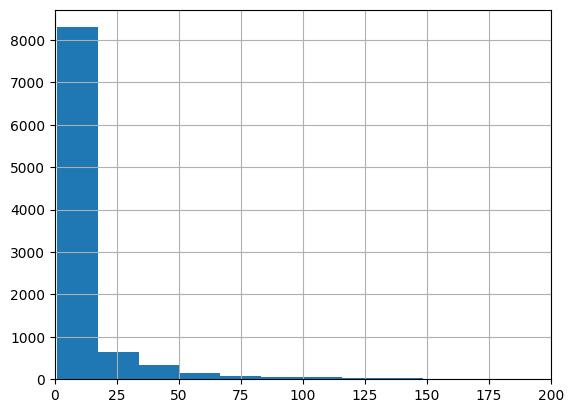

In [46]:
# Plot a histogram of the values in sorted_occupied_count
sorted_occupied_count.hist(bins=20)
plt.xlim(0, 200)
plt.show() #  You will notice that a very large proportion of the user_ratings_table movies have only one review. This would cause a large amount of difficulty if you were attempting to use KNN as there would not be enough valid 'neighbors'.

Example of simple matrix decomposition and reconstruction error

In [47]:
# Create the DataFrame
data = {
    'Alien': [5.0, 2.0, 1.0, 4.0, 1.0],
    'Scream': [4.0, 1.0, 3.0, 5.0, 1.0],
    'Scream 2': [3.0, 4.0, 3.0, 3.0, 4.0],
    'Love Actually': [2.0, 4.0, 5.0, 1.0, 5.0],
    'The Notebook': [1.0, 5.0, 4.0, 2.0, 5.0]
}

index = ['User_1', 'User_2', 'User_3', 'User_4', 'User_5']

original_df = pd.DataFrame(data, index=index)

original_df


,Alien,Scream,Scream 2,Love Actually,The Notebook
User_1,5.0,4.0,3.0,2.0,1.0
User_2,2.0,1.0,4.0,4.0,5.0
User_3,1.0,3.0,3.0,5.0,4.0
User_4,4.0,5.0,3.0,1.0,2.0
User_5,1.0,1.0,4.0,5.0,5.0


In [48]:
nmf = NMF(n_components=2, init='random', random_state=0)

In [49]:
W = nmf.fit_transform(original_df) # e.g. two components user matrix
W

array([[0.51510551, 2.70891022],
       [1.60639304, 0.39515534],
       [1.50881688, 0.6286404 ],
       [0.52510886, 2.70005026],
       [1.77624188, 0.        ]])

In [50]:
H = nmf.components_ # eg two components items (movies) matrix
H

array([[0.50992127, 0.67121371, 2.12561812, 2.84171369, 2.86605611],
       [1.54954903, 1.55904504, 0.68170857, 0.02293684, 0.        ]])

In [51]:
# Multiply the user and item matrices
reconstructed_df = np.dot(W, H)

reconstructed_df

array([[4.46025245, 4.56905893, 2.94160492, 1.52591623, 1.4763213 ],
       [1.43144655, 1.694298  , 3.68395893, 4.57397271, 4.60401257],
       [1.74348694, 1.99281727, 3.63571805, 4.30204461, 4.32435382],
       [4.45162443, 4.56196025, 2.95682832, 1.55413967, 1.50499146],
       [0.90574352, 1.1922379 , 3.77561194, 5.04757089, 5.0908089 ]])

Normalize your data

Before you can find the factors of the ratings matrix using singular value decomposition, you will need to "de-mean", or center it, by subtracting each row's mean from each value in that row.

In this exercise, you will begin prepping the movie rating DataFrame you have been working with in order to be able to perform Singular value decomposition.

In [58]:
# Get the average rating for each user 
avg_ratings = user_ratings_table.mean(axis=1)

avg_ratings

userId
1      4.366379
2      3.948276
3      2.435897
4      3.555556
5      3.636364
         ...   
606    3.657399
607    3.786096
608    3.134176
609    3.270270
610    3.688556
Length: 610, dtype: float64

In [60]:
# Center each user's ratings around 0
user_ratings_centered = user_ratings_table.subtract(avg_ratings, axis=0)

#print shapes
print(user_ratings_table.shape)
print(user_ratings_centered.shape)

(610, 9719)
(610, 9719)


In [61]:
            
# Fill in all missing values with 0s
user_ratings_centered.fillna(0, inplace=True)                                                  
                                                  
# Print the mean of each column
print(user_ratings_centered.mean(axis=1)) # to verify that the mean of each row is now zero (very close to)

userId
1      4.386518e-18
2      6.397005e-19
3      8.681649e-19
4      4.569289e-18
5      5.483147e-19
           ...     
606   -1.900824e-17
607   -3.655431e-19
608   -1.553558e-17
609    3.655431e-19
610   -5.286668e-17
Length: 610, dtype: float64


Decomposing your matrix

Now that you have prepped your data by centering it and filling in the remaining empty values with 0, you can get around to finding your data's factors. In this exercise, you will break the user_ratings_centered data you generated in the last exercise into 3 factors: U, sigma, and Vt.

U is a matrix with a row for each user

Vt has a column for each movie

sigma is an array of weights that you will need to convert to a diagonal matrix

In [62]:
# Decompose the matrix
U, sigma, Vt = svds(user_ratings_centered.values)

print(user_ratings_centered.shape)
print(U.shape, sigma.shape, Vt.shape)
U, sigma, Vt

(610, 9719)
(610, 6) (6,) (6, 9719)


(array([[ 0.01969478, -0.00561336, -0.00923111, -0.00024908,  0.00805328,
          0.02441005],
        [-0.00237548,  0.00095481,  0.00139727,  0.00140931, -0.00273796,
         -0.00069988],
        [-0.00943637,  0.00994295,  0.01221514, -0.00324512, -0.00643365,
         -0.00372421],
        ...,
        [-0.15048367, -0.08420507,  0.16038126,  0.09723828,  0.07666653,
          0.12897325],
        [ 0.00495832, -0.00287373,  0.00020863,  0.00452684,  0.00173436,
          0.00379533],
        [-0.00359908,  0.09116794,  0.13523257,  0.06399859, -0.12510252,
          0.16681144]]),
 array([36.54884233, 37.95486323, 39.37049297, 41.77886272, 43.62209292,
        76.20047266]),
 array([[-3.06689038e-05,  5.22030317e-05, -3.29286249e-05, ...,
         -1.17911835e-03,  1.26141842e-03,  9.39763155e-04],
        [ 7.48091302e-04,  1.05586239e-05, -2.04916461e-05, ...,
         -2.44619241e-03, -8.50893687e-03,  7.29930614e-04],
        [ 1.06976974e-03, -2.26134515e-04,  8.06459080e

In [63]:
# Convert sigma into a diagonal matrix
sigma = np.diag(sigma)
print(sigma)

[[36.54884233  0.          0.          0.          0.          0.        ]
 [ 0.         37.95486323  0.          0.          0.          0.        ]
 [ 0.          0.         39.37049297  0.          0.          0.        ]
 [ 0.          0.          0.         41.77886272  0.          0.        ]
 [ 0.          0.          0.          0.         43.62209292  0.        ]
 [ 0.          0.          0.          0.          0.         76.20047266]]


Recalculating the matrix

Now that you have your three factor matrices, you can multiply them back together to get complete ratings data without missing values. In this exercise, you will use numpy's dot product function to multiply U and sigma first, then the result by Vt. You will then be able add the average ratings for each row to find your final ratings.

In [65]:
# Dot product of U and sigma
U_sigma = np.dot(U, sigma)

print(U_sigma.shape)
U_sigma

(610, 6)


array([[ 7.19821515e-01, -2.13054261e-01, -3.63433458e-01,
        -1.04063363e-02,  3.51301100e-01,  1.86005748e+00],
       [-8.68210110e-02,  3.62397283e-02,  5.50111223e-02,
         5.88794996e-02, -1.19435386e-01, -5.33313046e-02],
       [-3.44888366e-01,  3.77383384e-01,  4.80915957e-01,
        -1.35577466e-01, -2.80649332e-01, -2.83786917e-01],
       ...,
       [-5.50000385e+00, -3.19599177e+00,  6.31428937e+00,
         4.06250464e+00,  3.34435470e+00,  9.82782224e+00],
       [ 1.81220814e-01, -1.09072020e-01,  8.21393240e-03,
         1.89126055e-01,  7.56562211e-02,  2.89206093e-01],
       [-1.31542360e-01,  3.46026685e+00,  5.32417277e+00,
         2.67378821e+00, -5.45723358e+00,  1.27111104e+01]])

In [66]:
# Dot product of result and Vt
U_sigma_Vt = np.dot(U_sigma, Vt)

print(U_sigma_Vt.shape)
U_sigma_Vt

(610, 9719)


array([[ 3.79170615e-04,  4.84563904e-04, -2.61967119e-04, ...,
        -8.99382376e-03, -2.00420729e-02,  3.59811437e-04],
       [ 1.87029825e-04, -2.33359845e-05,  1.69974933e-05, ...,
        -1.92178935e-03,  2.54179560e-03, -1.29211791e-04],
       [ 7.99870944e-04, -2.38877435e-04,  9.88144003e-05, ...,
        -5.53081195e-03,  5.89765832e-03, -5.48089213e-04],
       ...,
       [ 1.01841290e-02,  1.42962882e-03, -7.12667769e-04, ...,
        -1.61838994e-01, -6.33999363e-02, -1.76449435e-02],
       [ 1.41464063e-04,  1.15835786e-04, -4.86811191e-05, ...,
        -3.73637850e-03, -1.79761764e-03, -1.58713984e-05],
       [ 2.31044397e-02,  1.22098718e-03, -6.99805653e-04, ...,
        -2.69510650e-01,  4.41427463e-03, -9.48168294e-03]])

In [70]:
avg_ratings.values.reshape(-1, 1).shape

(610, 1)

In [71]:
# Add back on the row means contained in avg_ratings
uncentered_ratings = U_sigma_Vt + avg_ratings.values.reshape(-1, 1)

uncentered_ratings

array([[4.36675848, 4.36686387, 4.36611734, ..., 4.35738549, 4.34633724,
        4.36673912],
       [3.94846289, 3.94825253, 3.94829286, ..., 3.94635407, 3.95081766,
        3.94814665],
       [2.43669731, 2.43565856, 2.43599625, ..., 2.43036662, 2.44179509,
        2.43534935],
       ...,
       [3.14435982, 3.13560532, 3.13346302, ..., 2.9723367 , 3.07077576,
        3.11653075],
       [3.27041173, 3.27038611, 3.27022159, ..., 3.26653389, 3.26847265,
        3.2702544 ],
       [3.71166051, 3.68977705, 3.68785626, ..., 3.41904542, 3.69297034,
        3.67907438]])

In [75]:
# Create DataFrame of the results
calc_pred_ratings_df = pd.DataFrame(uncentered_ratings, 
                                    index=user_ratings_table.index,
                                    columns=user_ratings_table.columns
                                   )
# Print both the recalculated matrix and the original 
calc_pred_ratings_df

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.366758,4.366864,4.366117,4.366425,4.365874,4.367775,4.364110,4.365298,4.399567,4.366379,...,4.360731,4.365497,4.367345,4.366390,4.366333,4.387607,4.335274,4.357385,4.346337,4.366739
2,3.948463,3.948253,3.948293,3.948273,3.948342,3.948062,3.949374,3.948554,3.945010,3.948521,...,3.946941,3.949843,3.947476,3.947203,3.948247,3.945910,3.945743,3.946354,3.950818,3.948147
3,2.436697,2.435659,2.435996,2.435841,2.436166,2.435715,2.442690,2.438575,2.420862,2.439383,...,2.437677,2.441960,2.432665,2.431460,2.435774,2.427541,2.436665,2.430367,2.441795,2.435349
4,3.553547,3.556060,3.555342,3.555822,3.555180,3.558750,3.493632,3.545681,3.531246,3.544048,...,3.528199,3.539657,3.563222,3.566525,3.555780,3.588758,3.542657,3.579806,3.533643,3.557405
5,3.636042,3.636611,3.636259,3.636443,3.636168,3.637921,3.632567,3.635113,3.639293,3.635552,...,3.635141,3.632319,3.638571,3.639009,3.636443,3.645666,3.635973,3.638589,3.627942,3.636997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.656747,3.660728,3.655946,3.658587,3.655294,3.677603,3.553893,3.638496,3.686535,3.674837,...,3.665024,3.630286,3.673631,3.673444,3.658190,3.796002,3.655214,3.648094,3.530404,3.662434
607,3.785770,3.786352,3.785971,3.786110,3.785747,3.785805,3.790275,3.784962,3.821457,3.787387,...,3.796064,3.783058,3.788082,3.788376,3.786204,3.794007,3.789866,3.783980,3.777680,3.786174
608,3.144360,3.135605,3.133463,3.134770,3.134419,3.111664,2.848560,3.096719,3.385000,3.245631,...,3.290693,3.227688,3.091068,3.072951,3.134055,3.219383,3.175218,2.972337,3.070776,3.116531


Making recommendations with SVD

Now that you have the recalculated matrix with all of its gaps filled in, the next step is to use it to generate predictions and recommendations.

Using calc_pred_ratings_df that you generated in the last exercise, with all rows and columns filled, find the movies that User_5 is most likely to enjoy.

In [79]:
calc_pred_ratings_df.loc[5].sort_values(ascending = False).head()

title
Pulp Fiction (1994)                 3.729587
Schindler's List (1993)             3.718425
Godfather, The (1972)               3.712649
Shawshank Redemption, The (1994)    3.712342
Fargo (1996)                        3.707741
Name: 5, dtype: float64

Comparing recommendation methods

In this course, you have predicted how you believe a user would rate movies they have not seen using multiple different methods (basic average ratings, KNN, matrix factorization). In this final exercise, you'll work through a comparison of the averaged ratings and matrix factorization using the mean_squared_error() as the measure of how well they are performing. 

In [109]:
# let's just fill the user row values of the original users movies table with the averages of each user row, to get a naive table to calculate the mean squared error

avg_pred_ratings_df = user_ratings_table.apply(lambda row: pd.Series(avg_ratings[row.name], index=row.index), axis=1)

avg_pred_ratings_df

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,...,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379
2,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,...,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276
3,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,...,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897
4,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,...,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556
5,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,...,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.657399,3.657399,3.657399,3.657399,3.657399,3.657399,3.657399,3.657399,3.657399,3.657399,...,3.657399,3.657399,3.657399,3.657399,3.657399,3.657399,3.657399,3.657399,3.657399,3.657399
607,3.786096,3.786096,3.786096,3.786096,3.786096,3.786096,3.786096,3.786096,3.786096,3.786096,...,3.786096,3.786096,3.786096,3.786096,3.786096,3.786096,3.786096,3.786096,3.786096,3.786096
608,3.134176,3.134176,3.134176,3.134176,3.134176,3.134176,3.134176,3.134176,3.134176,3.134176,...,3.134176,3.134176,3.134176,3.134176,3.134176,3.134176,3.134176,3.134176,3.134176,3.134176


In [114]:
# let's select some df slices over which to calculate the mean squared error
actual_values = user_ratings_table.iloc[:200, :2000].values
avg_values = avg_pred_ratings_df.iloc[:200, :2000].values
svd_predicted_values = calc_pred_ratings_df.iloc[:200, :2000].values

# Create a mask of actual_values to only look at the non-missing values in the ground truth
mask = ~np.isnan(actual_values)

actual_values[mask].shape

(6157,)

In [115]:
# Print the performance of both predictions and compare
print(mean_squared_error(actual_values[mask], avg_values[mask], squared=False))
print(mean_squared_error(actual_values[mask], svd_predicted_values[mask], squared=False))

0.9514828193512334
0.897513996215398
